# Clustering synthesis methods by similarity
Use this notebook to explain what SnyOracle is and does in a specific ordered fashion

In [12]:
%colors nocolor

In [13]:
import os
import sys
import matplotlib.pyplot as plt

try:
    from synoracle.interpret import sequence, ingredients
except ModuleNotFoundError:
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)
    from synoracle.interpret import sequence, ingredients

In [14]:

from glob import glob
from tqdm.notebook import tqdm, trange
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import json
def li_iterate(li):
    l = iter(li)
    for _ in trange(len(li)):
        yield next(l)
import matplotlib.pyplot as plt

In [15]:
with open('./exported json files/broken_down_boms.json', 'r', encoding='utf-8') as f:
    rawdata = json.loads(f.read())

left = pd.DataFrame(rawdata).set_index('level_0')
left.index = left.index.rename('pubchem_id').astype(int)

In [16]:
with open('./exported json files/chemical_typing_crossreference.json', 'r', encoding='utf-8') as f:
    xref = json.loads(f.read())
right = pd.DataFrame(xref)
right.index = right.index.rename('pubchem_id').astype(int)

In [17]:
all_boms = pd.merge(left=left, right=right, left_index=True, right_index=True)

In [18]:
all_boms[(all_boms['synthesis_number']==0) & (all_boms['step type']=='add')]

,step type,name,moles,synthesis_number,index,contains_imidazole,contains_nitrate,contains_sulfate,contains_acetate,contains_chloride,contains_oxide,contains_zinc,contains_cobalt,contains_acid,contains_base,contains_amphoteric,contains_surfactant,contains_solvent
pubchem_id,,,,,,,,,,,,,,,,,,
962,add,[H2O],1.101671,0,0.0,False,False,False,False,False,False,False,False,False,False,False,False,True
12749,add,[2-methylimidazole],0.002000,0,1.0,True,False,False,False,False,False,False,False,False,False,False,False,False
24821,add,[Co(NO3)2·6H2O],0.000500,0,2.0,False,True,False,False,False,False,False,True,False,False,False,False,False
5462310,add,[carbon],0.004995,0,3.0,False,False,False,False,False,False,False,False,False,False,False,False,False


In [19]:
all_syn_chems = {}
counter = 0
counter_to_synthesis_map = {}
for syn_index in li_iterate(all_boms['synthesis_number'].unique()):
    syn_chems = []
    filters = ['contains_cobalt',
                  'contains_zinc',
                  'contains_sulfate',
                  'contains_chloride',
                  'contains_nitrate',
                  'contains_oxide',
                  'contains_acetate']
    working = all_boms[all_boms['synthesis_number']==syn_index]
  
    filtered_working = working[(~np.where(
        working['contains_cobalt'] | working['contains_zinc'] | \
        working['contains_sulfate'] | working['contains_chloride'] |\
        working['contains_nitrate'] | working['contains_oxide'] |\
        working['contains_acetate'] | working['contains_imidazole'],
        True, 
        False)) & (working['step type']=='add')]
   # display(list(set(filtered_working.index)))
    if 12749 in working.index:
        for x in filters:
            if not working[working[x]].empty:
                syn_chems.append(x)
        syn_chems.extend(
            [y for y in list(set(filtered_working.index))]
        )

        # print(syn_chems)

        all_syn_chems[counter] = ' '.join(sorted([str(x) for x in syn_chems]))
        counter_to_synthesis_map[counter] = syn_index
        counter +=1

  0%|          | 0/1599 [00:00<?, ?it/s]

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pickle

words_rep = pd.DataFrame(all_syn_chems, index=['Name']).T.reset_index().rename({'index': 'synthesis_number'}, axis=1)
words_rep['source'] = 'els-rsc'


vectorizer_wtf = TfidfVectorizer(analyzer='word')
X_wtf = vectorizer_wtf.fit_transform(words_rep['Name'])

pickle.dump(vectorizer_wtf.vocabulary_,open('./data/knn_vocal_3.pkl', 'wb'))
pd.concat([words_rep,pd.DataFrame(X_wtf.toarray(), columns=vectorizer_wtf.get_feature_names())], axis=1).head()


,synthesis_number,Name,source,10005,1004,10154203,1118,11251951,11281299,1133,...,944,947,962,contains_acetate,contains_chloride,contains_cobalt,contains_nitrate,contains_oxide,contains_sulfate,contains_zinc
0,0,887 contains_cobalt,els-rsc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.796472,0.000000,0.0,0.0,0.000000
1,1,174 887 contains_nitrate contains_zinc,els-rsc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.185142,0.0,0.0,0.214375
2,2,962 contains_cobalt contains_nitrate contains_...,els-rsc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.658145,0.000000,0.0,0.547519,0.337782,0.0,0.0,0.391116
3,3,174 702 contains_nitrate contains_zinc,els-rsc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.164629,0.0,0.0,0.190623
4,4,174 5462310 944 contains_acetate contains_coba...,els-rsc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.605817,0.0,0.000000,0.288855,0.0,0.171317,0.105691,0.0,0.0,0.122379


## DBSCAN clustering and TSNE visualisation

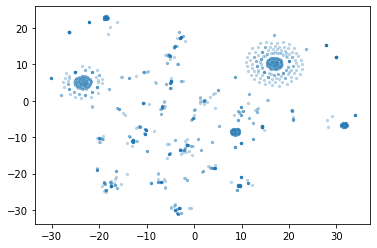

In [143]:
from sklearn.manifold import TSNE
# Create a TSNE instance: model
model = TSNE( metric='euclidean', random_state=5)

# Apply fit_transform to samples: tsne_features
tsne_features = model.fit_transform(X_wtf.toarray())

# Select the 0th feature: xs
xs = tsne_features[:, 0]

# Select the 1st feature: ys
ys = tsne_features[:, 1]

# Scatter plot, coloring by variety_numbers
plt.scatter(xs, ys, alpha=0.25, s=5)

In [144]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.1, min_samples=20).fit(X_wtf.toarray())
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 8
Estimated number of noise points: 574


In [145]:
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7}

In [228]:
from collections import Counter
lbl_no = 7
display(Counter(words_rep['Name'][labels==lbl_no]).most_common(7))
display(words_rep['Name'][labels==lbl_no].head())
print(len(words_rep['Name'][labels==lbl_no]))

print(tsne_features[words_rep.index[labels==lbl_no][1]])

[('887 962 contains_nitrate contains_zinc', 20)]

319    887 962 contains_nitrate contains_zinc
416    887 962 contains_nitrate contains_zinc
480    887 962 contains_nitrate contains_zinc
516    887 962 contains_nitrate contains_zinc
535    887 962 contains_nitrate contains_zinc
Name: Name, dtype: object

20
[14.346849  -6.9953156]


In [229]:
tsne_features[977]

array([ 8.33919 , -8.380775], dtype=float32)

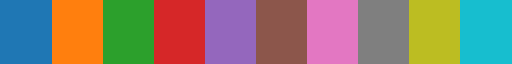

In [230]:
cmap

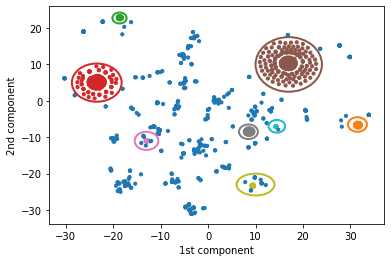

In [239]:
from matplotlib.patches import Ellipse
import matplotlib.cm as cm
cmap = cm.get_cmap('tab10')

fig, ax = plt.subplots()

ax.scatter(xs, ys, alpha=1, s=10, cmap=cmap, c=labels)

# no. 0: 
# zinc, nitrate
# 39 synths
el1 = Ellipse((31.5,-6.5), 4, 4,  facecolor='none', edgecolor=cmap(1), linewidth=2)
ax.add_artist(el1)

# no. 1
# zinc, cobalt, nitrate, methanol
# 31
el2 = Ellipse((-18.7,22.75), 3, 3,  facecolor='none', edgecolor=cmap(2), linewidth=2)
ax.add_artist(el2)

# no. 2
# cobalt, nitrate, methanol
# 148
el3 = Ellipse((-23.5,5), 10.5, 10.5,  facecolor='none', edgecolor=cmap(3), linewidth=2)
ax.add_artist(el3)

# no. 3
# zinc, nitrate, methanol
# 225
el4 = Ellipse((17,10), 14, 15,  facecolor='none', edgecolor=cmap(5), linewidth=2)
ax.add_artist(el4)

# no. 4
# zinc, acetate, water
# 22
el5 = Ellipse((-13,-11), 5, 5,  facecolor='none', edgecolor=cmap(6), linewidth=2)
ax.add_artist(el5)

# no. 5
# zinc, nitrate, water
# 50
el6 = Ellipse((8.5, -8.5), 4, 4,  facecolor='none', edgecolor=cmap(7), linewidth=2)
ax.add_artist(el6)

# no. 6
# cobalt, nitrate, water
# 25
el7 = Ellipse((10,-23), 8, 6,  facecolor='none', edgecolor=cmap(8), linewidth=2)
ax.add_artist(el7)

# no. 9:
# zinc, nitrate, methanol, water
# 20
el8 = Ellipse((14.5,-7), 3.5, 3.5,  facecolor='none', edgecolor=cmap(9), linewidth=2)
ax.add_artist(el8)

ax.set_ylabel('2nd component')
ax.set_xlabel('1st component')

plt.show()